In [111]:
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt

from Utils.functions import *

<h3>Choosing rotation coordinates</h3>

The figure needs a point to rotate from, said coordinate can be chosen randomly.

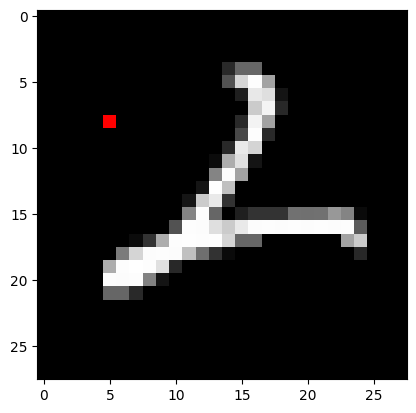

In [112]:
mnist = pd.read_csv('MNIST/mnist_test.csv')

image,_ = getImageArray(43,mnist)
# rotationAxis = (25,15)
rotationAxis = (random.randint(0,image.shape[0]),random.randint(0,image.shape[1]))

display = image.copy()
display[rotationAxis] = [255,0,0]
plt.imshow(display)
plt.show()

<h3>Inserting image with selected coordinates</h3>

It is necessary to introduce the image on top of a blank image big enough to support rotation without any loss of data. For this a blank squared canvass is created, measuring twice the diagonal of the original digit. A function is created to insert images so the center of the canvass coincides with the selected rotation axis.

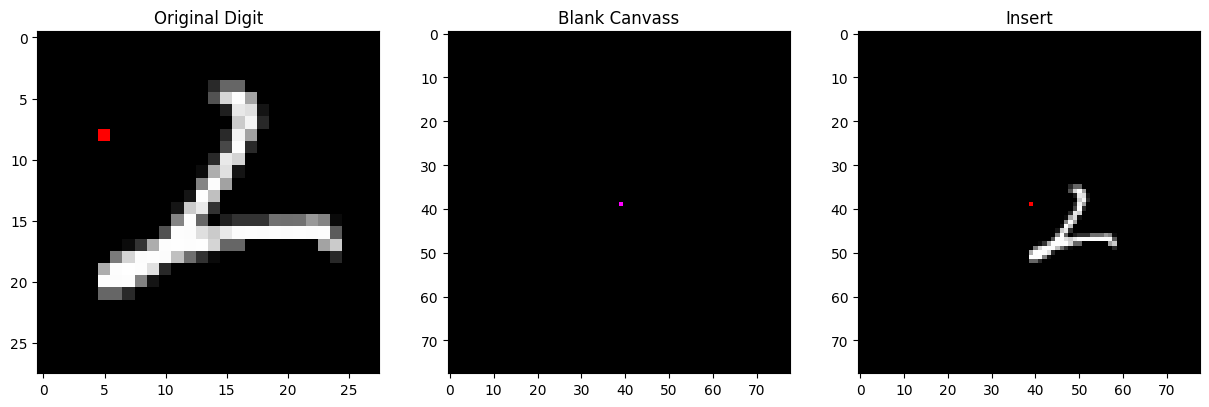

In [113]:
# Adds insert into image so both coordinates coincide
def insertPointOnPoint(ins, pointInsert, image, pointImage):
    insertCoord = (pointImage[0]-pointInsert[0], pointImage[1]-pointInsert[1])
    insert(ins, image, insertCoord)

diagonal = int((image.shape[0]**2 + image.shape[1]**2)**0.5)
result = np.zeros((diagonal*2, diagonal*2, 3)).astype(np.uint8)
result[diagonal, diagonal] = [255,0,255]
canvass = result.copy()
rotAxis = (diagonal, diagonal)
insertPointOnPoint(display, rotationAxis, result, rotAxis)


_, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(display), ax[0].set_title(f'Original Digit')
ax[1].imshow(canvass), ax[1].set_title(f'Blank Canvass')
ax[2].imshow(result), ax[2].set_title(f'Insert')
plt.show()

<h3>Rotation</h3>

Once the order of symmetry is chosen, the desired degrees of rotation can be calculated. By rotating the original images incrementally by the rotation axis and adding all of them together the symmetry can be created. Here is an example of an order 3.

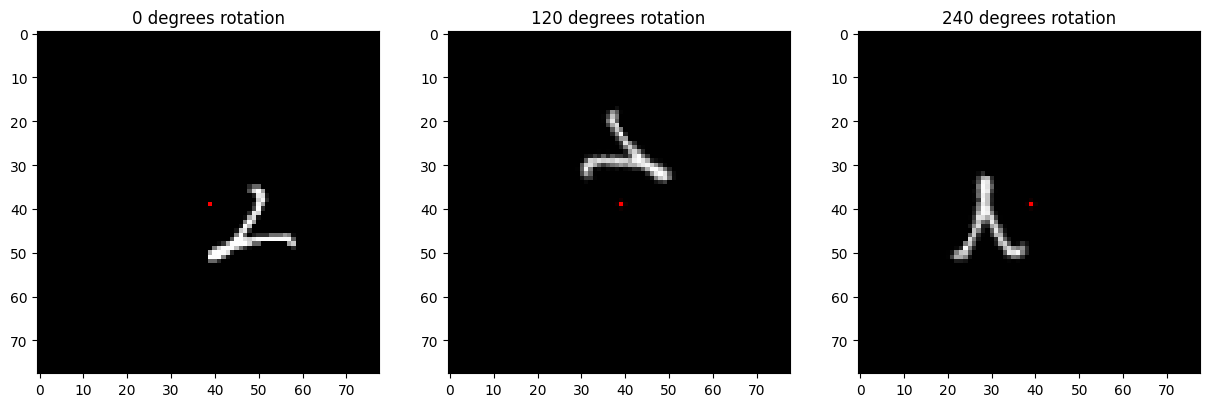

In [114]:
# Performs set step in rotation
def performRotationStep(img, rotAxis, order, step):
    rotationStep = 360.0 / order
    rotationMatrix = cv2.getRotationMatrix2D(rotAxis, rotationStep * step, 1)
    return cv2.warpAffine(img, rotationMatrix, img.shape[:2])

rotatedStep = []
for i in range(3):
    rotatedStep.append(performRotationStep(result, rotAxis, 3, i))

_, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(rotatedStep[0]), ax[0].set_title(f'0 degrees rotation')
ax[1].imshow(rotatedStep[1]), ax[1].set_title(f'120 degrees rotation')
ax[2].imshow(rotatedStep[2]), ax[2].set_title(f'240 degrees rotation')
plt.show()

<h3>Adding all the rotations together</h3>

A function is created to add all the rotated images. After, the unnecesary padding is removed

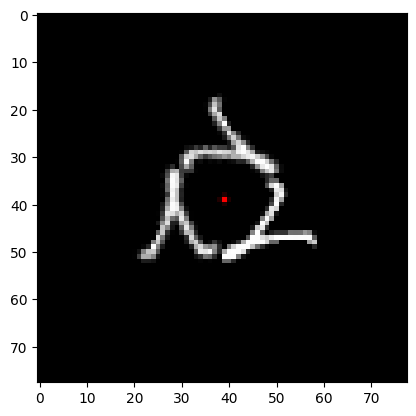

In [115]:
# Adds all images in list on top of each other
def addAllImages(listImages, overflow = True):
    result = listImages[0].copy()
    for img in listImages[1:]:
        if overflow:
            result = np.add(result, img)
        else:
            result = addNoOverflow(result,img)
    return result

union = addAllImages(rotatedStep)
# croppedUnion, _, _, newCenter = removePadding(union, [0,0], [0,0], rotAxis)

plt.imshow(union)
plt.show()

<h3>Remove padding</h3>

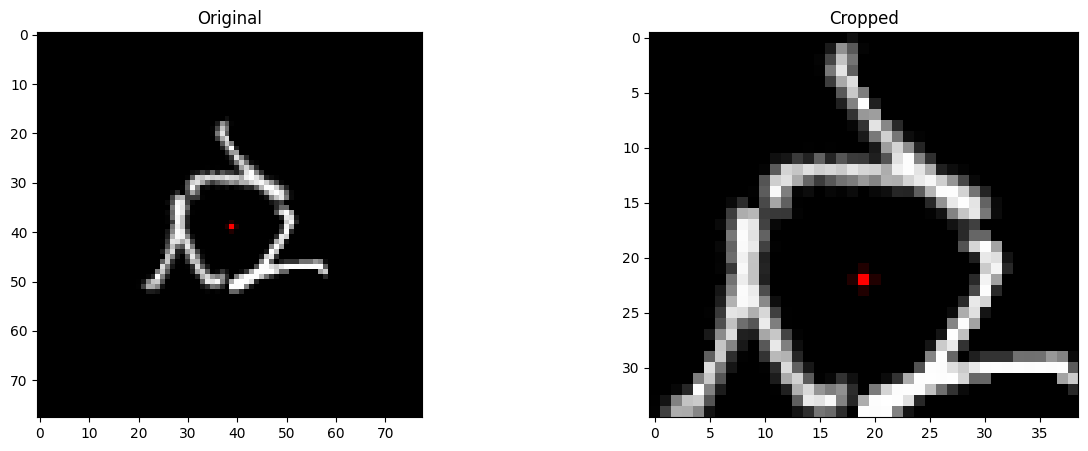

In [116]:
cropped, _, _, newAxis = removePadding(union, [0,0], [0,0], rotAxis)
newAxis = (newAxis[1],newAxis[0])

_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(union), ax[0].set_title(f'Original')
ax[1].imshow(cropped), ax[1].set_title(f'Cropped')
plt.show()

<h2>Resize</h2>

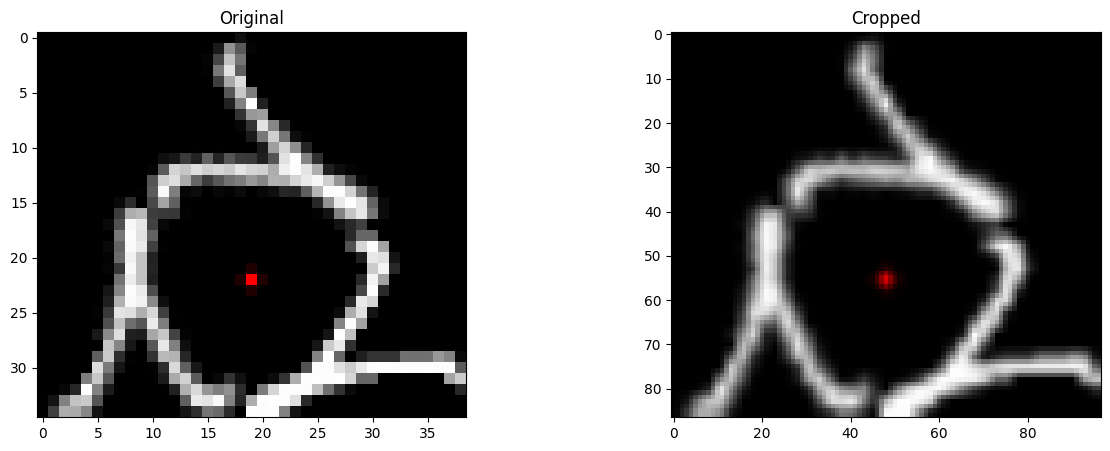

In [117]:
croppedResized, _, resizedAxis, _, _ = resizeSymmetryMultipleAxes(250, cropped, [], newAxis, 0, 0)

_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(cropped), ax[0].set_title(f'Original')
ax[1].imshow(croppedResized), ax[1].set_title(f'Cropped')
plt.show()

<h3>Putting everything together</h3>


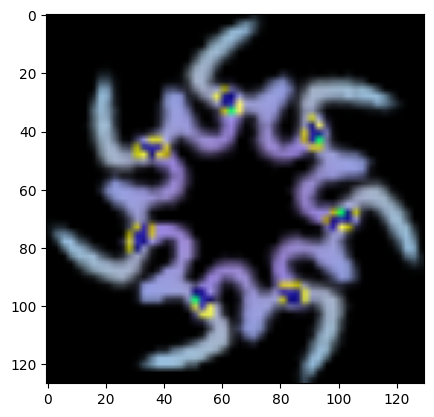

In [205]:
# Creates a rotational symmetry of the desired order
def createRotationalSymmetry(id, mnist, rotAxis = None, order = None, resizingPercent = None):
    result,label = getImageArray(id,mnist)
    result = applyColorGradient(result)

    # Selecting rotation axis
    if rotAxis is None:
        rotAxis = (random.randint(0,result.shape[0]),random.randint(0,result.shape[1]))

    # Inserting image in bigger canvass
    diagonal = int((result.shape[0]**2 + result.shape[1]**2)**0.5)
    canvass = np.zeros((diagonal*2, diagonal*2, 3)).astype(np.uint8)
    insertPointOnPoint(result, rotAxis, canvass, (diagonal, diagonal))

    # Selecting order
    if order is None:
        order = random.randint(3,10)

    # Performing rotation
    rotatedStep = []
    for i in range(order):
        rotatedStep.append(performRotationStep(canvass, (diagonal, diagonal), order, i))
    result = addAllImages(rotatedStep)

    # Remove padding
    result, _, _, newAxis = removePadding(result, [0,0], [0,0], (diagonal, diagonal))
    newAxis = (newAxis[1],newAxis[0])

    # Resize
    if resizingPercent is None:
        resizingPercent = random.randrange(80,300)
    result, _, resizedAxis, _, _ = resizeSymmetryMultipleAxes(250, result, [], newAxis, 0, 0)

    dict = {
        'rotationAxis': resizedAxis,
        'initialRotationAxis': rotAxis,
        'order': order,
        'resizingPercent': resizingPercent,
        'label': label
    }

    return result, dict

img, dict = createRotationalSymmetry(32, mnist)

plt.imshow(img)
plt.show()

<h4>Some Examples</h4>

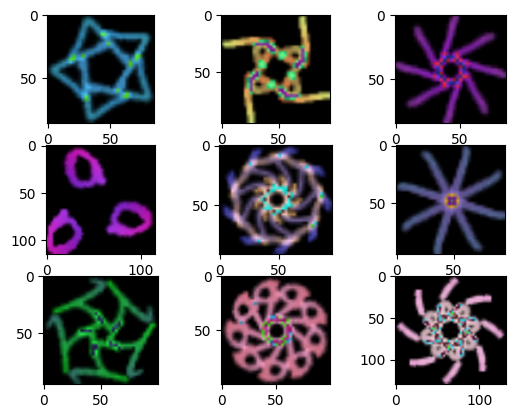

In [212]:
# Generating symmetries
images = []
for i in range(9):
    img, _ = createRotationalSymmetry(i, mnist)
    images.append(img)

#Displaying them
_, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(images[i*3+j])
plt.show()

<h3>Assymetric Rotational Symmetries</h3>

A problem that might arise with this approach when training a model with a dataset generated from this is that the model might predict the center of *circular* shapes instead of finding the rotational symmetries. For this it is necessary to generate examples with this rotation algorithm but different elements, to make them asymmetric.

In [ ]:
# def createRotationalAsymmetry(mnist):
    